# Explore Data
Perform some basic visualizations of the data. Then analyze the minimum number of slices we can interpolate over without oversampling the data. 

In [6]:
import glob
import matplotlib.pyplot as plt
import pandas as pd

SILVER_QA_PATH = '/usr/datalake/silver/igra/qa'
SILVER_STATION_LIST_PATH = '/usr/datalake/silver/igra/doc/igra2-station-list.csv'

In [7]:
# Get CSV files list from a folder
csv_files = glob.glob(SILVER_QA_PATH + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = (pd.read_csv(file) for file in csv_files)

# Pandas doesn't like to concatinate "empty" DataFrames
df_list = [dataframe for dataframe in df_list if dataframe.shape[0] > 0]

# Concatenate all DataFrames
df = pd.concat(df_list, ignore_index=True)

del df_list

df.head()

,id,effective_date,hour,usable_10k,usable_all,max_gph,min_pa
0,USM00072249,2000-01-01,0,24,63,28956.0,1300
1,USM00072249,2000-01-01,12,39,68,24114.0,2780
2,USM00072249,2000-01-02,0,1,1,198.0,98590
3,USM00072249,2000-01-02,12,42,44,10594.0,25000
4,USM00072249,2000-01-03,0,37,53,30775.0,1000


In [8]:
df_stations = pd.read_csv(SILVER_STATION_LIST_PATH)
df_stations.head()

,id,latitude,longitude,elevation,state,name,fst_year,lst_year,nobs
0,ACM00078861,17.1170,-61.7830,10.0,NaN,COOLIDGE FIELD (UA),1947,1993,13896
1,AEM00041217,24.4333,54.6500,16.0,NaN,ABU DHABI INTERNATIONAL AIRPOR,1983,2025,41006
2,AEXUAE05467,25.2500,55.3700,4.0,NaN,SHARJAH,1935,1942,2477
3,AFM00040911,36.7000,67.2000,378.0,NaN,MAZAR-I-SHARIF,2010,2014,2179
4,AFM00040913,36.6667,68.9167,433.0,NaN,KUNDUZ,2010,2013,4540


In [9]:
print(f"Total Observation Count: {df.shape[0]}")

Total Observation Count: 373919


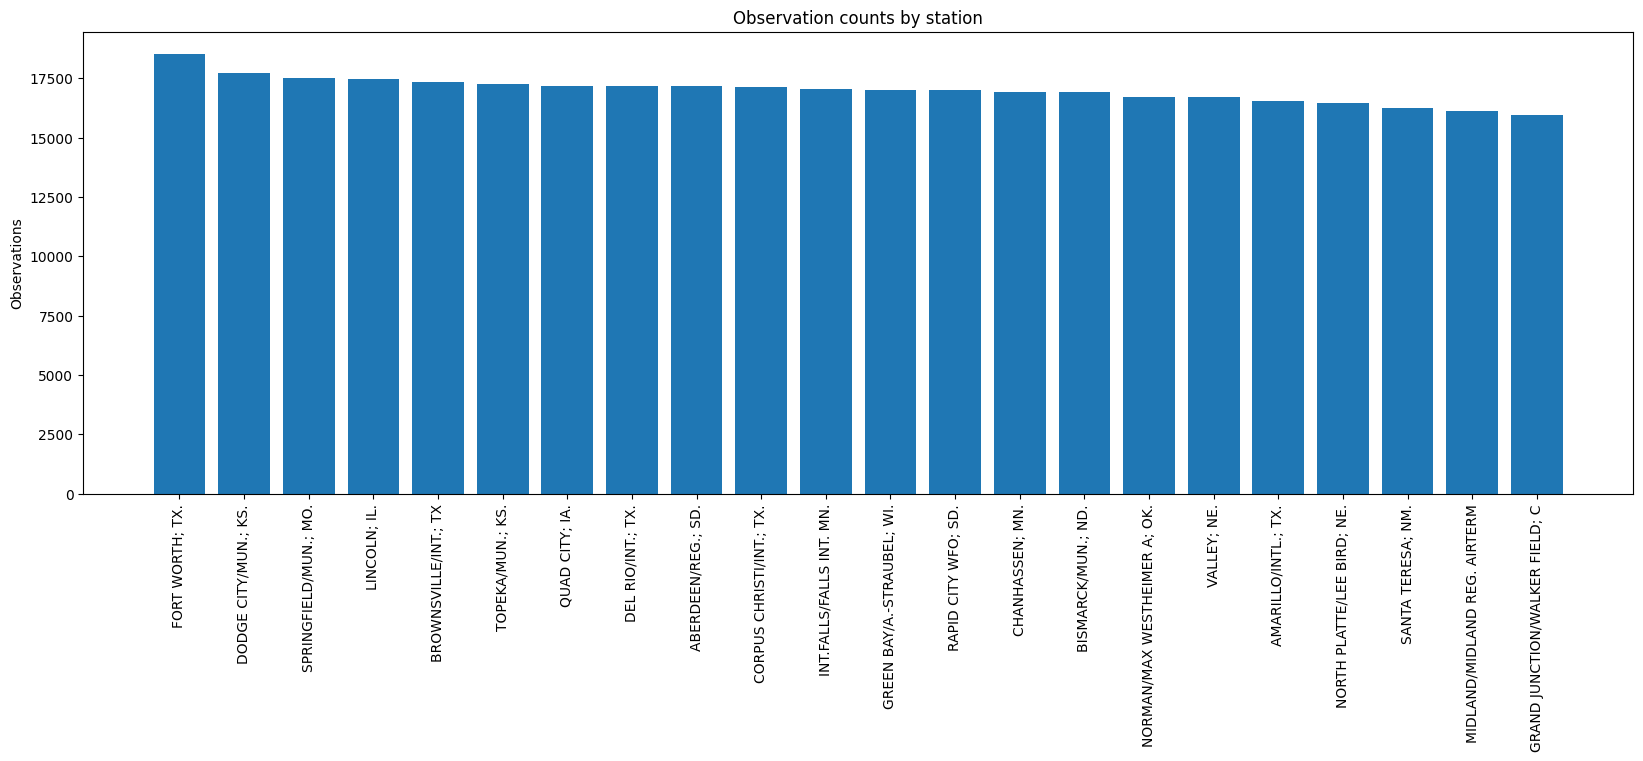

In [10]:
# SELECT l.name, COUNT(d.id) AS station_rows
# FROM df d INNER JOIN df_stations l ON d.id = l.id
# GROUP BY l.name
# ORDER BY station_rows DESC
query = df \
    .merge(df_stations, how='inner', on='id') \
    .groupby('name') \
    .agg(station_rows = ('id', 'count')) \
    .sort_values('station_rows', ascending=False)

fig, ax = plt.subplots(figsize=(20, 6))

ax.bar(query.index, query.station_rows)
ax.set_ylabel('Observations')
ax.set_title('Observation counts by station')
ax.tick_params(axis='x', labelrotation=90)

plt.show()

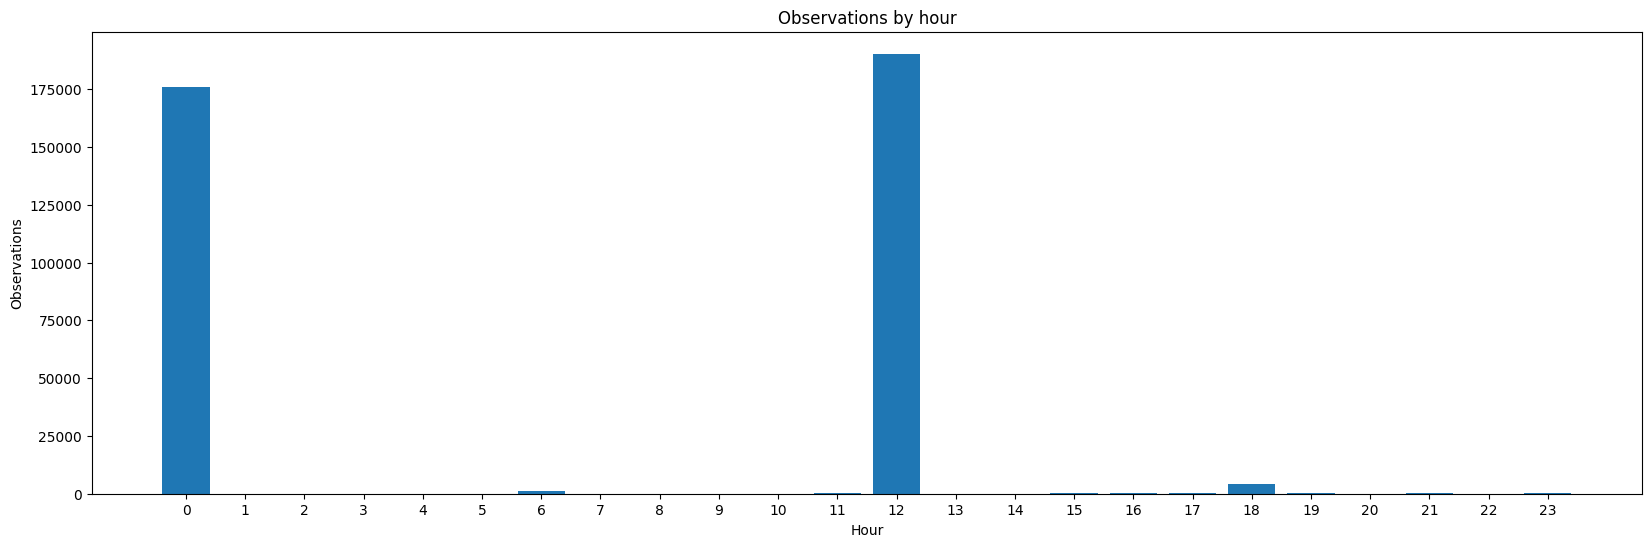

In [11]:
# SELECT hour, COUNT(id) AS obs_count
# FROM df 
# GROUP BY hour
query = df \
    .groupby('hour') \
    .agg(obs_count=('id', 'count'))

fig, ax = plt.subplots(figsize=(20, 6))

ax.bar(query.index, query.obs_count)
ax.set_ylabel('Observations')
ax.set_xlabel('Hour')
ax.set_title('Observations by hour')
ax.set_xticks(query.index) # Force to show all x-values
# ax.set_yscale('log') # Optional logarithmic y scale

plt.show()

In [31]:
# Show the mean number of datapoints between the surface and 10km geopotential height
#  Show the number of datapoints 1 standard deviation away from the mean
#  Show the number of datapoints 2 standard deviation away from the mean

# SELECT
#     l.name
#    ,ROUND(AVG(d.usable_10k), 1) AS avg_usable_10k
#    ,ROUND(AVG(d.usable_10k) - STD(d.usable_10k), 1) AS usable_10k_68
#    ,ROUND(AVG(d.usable_10k) - 2.0 * STD(d.usable_10k), 1) AS usable_10k_95
# FROM df d INNER JOIN df_stations l ON d.id = l.id
# WHERE hour = 12
# GROUP BY l.name
# ORDER BY avg_usable_10k DESC
print('Number of data points below 10km, 1 standard deviation (68%), and 2 standard deviations (96%)')
df[df.hour == 12] \
    .merge(df_stations, how='inner', on='id') \
    .groupby('name') \
    .agg(avg_usable_10k=('usable_10k', 'mean'),
         std_usable_10k=('usable_10k', 'std')) \
    .assign(z1_threshold = lambda df: round(df.avg_usable_10k - df.std_usable_10k, 1),
            z2_threshold = lambda df: round(df.avg_usable_10k - 2.0 * df.std_usable_10k, 1),
            mean = lambda df: round(df.avg_usable_10k, 1),
            std = lambda df: round(df.std_usable_10k, 1)) \
    .sort_values('mean', ascending=False) \
    [['mean', 'std', 'z1_threshold', 'z2_threshold']]

Number of data points below 10km, 1 standard deviation (68%), and 2 standard deviations (96%)


,mean,std,z1_threshold,z2_threshold
name,,,,
BROWNSVILLE/INT.; TX,50.0,20.2,29.8,9.5
QUAD CITY; IA.,48.6,20.7,27.9,7.2
TOPEKA/MUN.; KS.,48.4,19.2,29.2,10.0
CORPUS CHRISTI/INT.; TX.,48.3,18.4,29.9,11.6
NORMAN/MAX WESTHEIMER A; OK.,46.3,20.0,26.3,6.3
DEL RIO/INT.; TX.,44.9,22.1,22.8,0.7
INT.FALLS/FALLS INT. MN.,44.3,18.6,25.7,7.0
SPRINGFIELD/MUN.; MO.,43.4,18.1,25.3,7.2
FORT WORTH; TX.,43.4,17.2,26.2,8.9


In [32]:
# SELECT
#     l.name
#     ,COUNT(*) AS total_count
#     ,SUM(IF(usable_10k < 20, 1, 0)) AS thrown_out_count
#     ,ROUND(SUM(IF(usable_10k < 20, 1, 0)) / COUNT(*) * 100.0, 1) AS pct
# FROM df d INNER JOIN df_stations s ON s.id = d.id
# WHERE hour = 12
# GROUP BY s.name
# ORDER BY pct DESC;
print('Number of records thrown out with minimum threshold count of 20')
df[df.hour == 12] \
    .merge(df_stations, how='inner', on='id') \
    .assign(thrown_out=lambda df: df.usable_10k < 20) \
    .groupby('name') \
    .agg(total_count=('id', 'count'),
         thrown_out_count=('thrown_out', 'sum')) \
    .assign(pct=lambda df: round(df.thrown_out_count / df.total_count * 100.0, 1)) \
    .sort_values('pct', ascending=False)

Number of records thrown out with minimum threshold count of 20


,total_count,thrown_out_count,pct
name,,,
GRAND JUNCTION/WALKER FIELD; C,8511,446,5.2
AMARILLO/INTL.; TX.,8343,400,4.8
SANTA TERESA; NM.,8883,392,4.4
BISMARCK/MUN.; ND.,8662,382,4.4
DODGE CITY/MUN.; KS.,9117,384,4.2
RAPID CITY WFO; SD.,8628,324,3.8
MIDLAND/MIDLAND REG. AIRTERM,8357,273,3.3
GREEN BAY/A.-STRAUBEL; WI.,8564,256,3.0
LINCOLN; IL.,8746,253,2.9


In [14]:
# SELECT
#     s.name
#     ,min(usable_10k) AS whislo
#     ,percentile(usable_10k, 0.25) AS q1
#     ,percentile(usable_10k, 0.5) AS med
#     ,percentile(usable_10k, 0.75) AS q3
#     ,max(usable_10k) AS whishi
# FROM df d INNER JOIN df_stations s on d.id = s.id
# WHERE hour = 12
# GROUP BY s.name
# ORDER BY med
query = df[df.hour == 12] \
    .merge(df_stations, how='inner', on='id') \
    .groupby('name')['usable_10k'] \
    .quantile([0.0, 0.25, 0.5, 0.75, 1.0]).unstack() \
    .rename(columns={0: 'whislo', 0.25: 'q1', 0.5: 'med', 0.75: 'q3', 1: 'whishi'}) \
    .sort_values('med')

query

,whislo,q1,med,q3,whishi
name,,,,,
GRAND JUNCTION/WALKER FIELD; C,1.0,25.0,29.0,35.0,101.0
AMARILLO/INTL.; TX.,1.0,27.0,32.0,39.0,108.0
SANTA TERESA; NM.,1.0,26.0,32.0,39.0,108.0
RAPID CITY WFO; SD.,1.0,27.0,32.0,38.0,106.0
MIDLAND/MIDLAND REG. AIRTERM,1.0,27.0,33.0,41.0,120.0
DODGE CITY/MUN.; KS.,1.0,27.0,33.0,41.0,121.0
NORTH PLATTE/LEE BIRD; NE.,1.0,29.0,34.0,40.0,115.0
BISMARCK/MUN.; ND.,1.0,29.0,35.0,42.0,123.0
GREEN BAY/A.-STRAUBEL; WI.,1.0,30.0,36.0,44.0,140.0


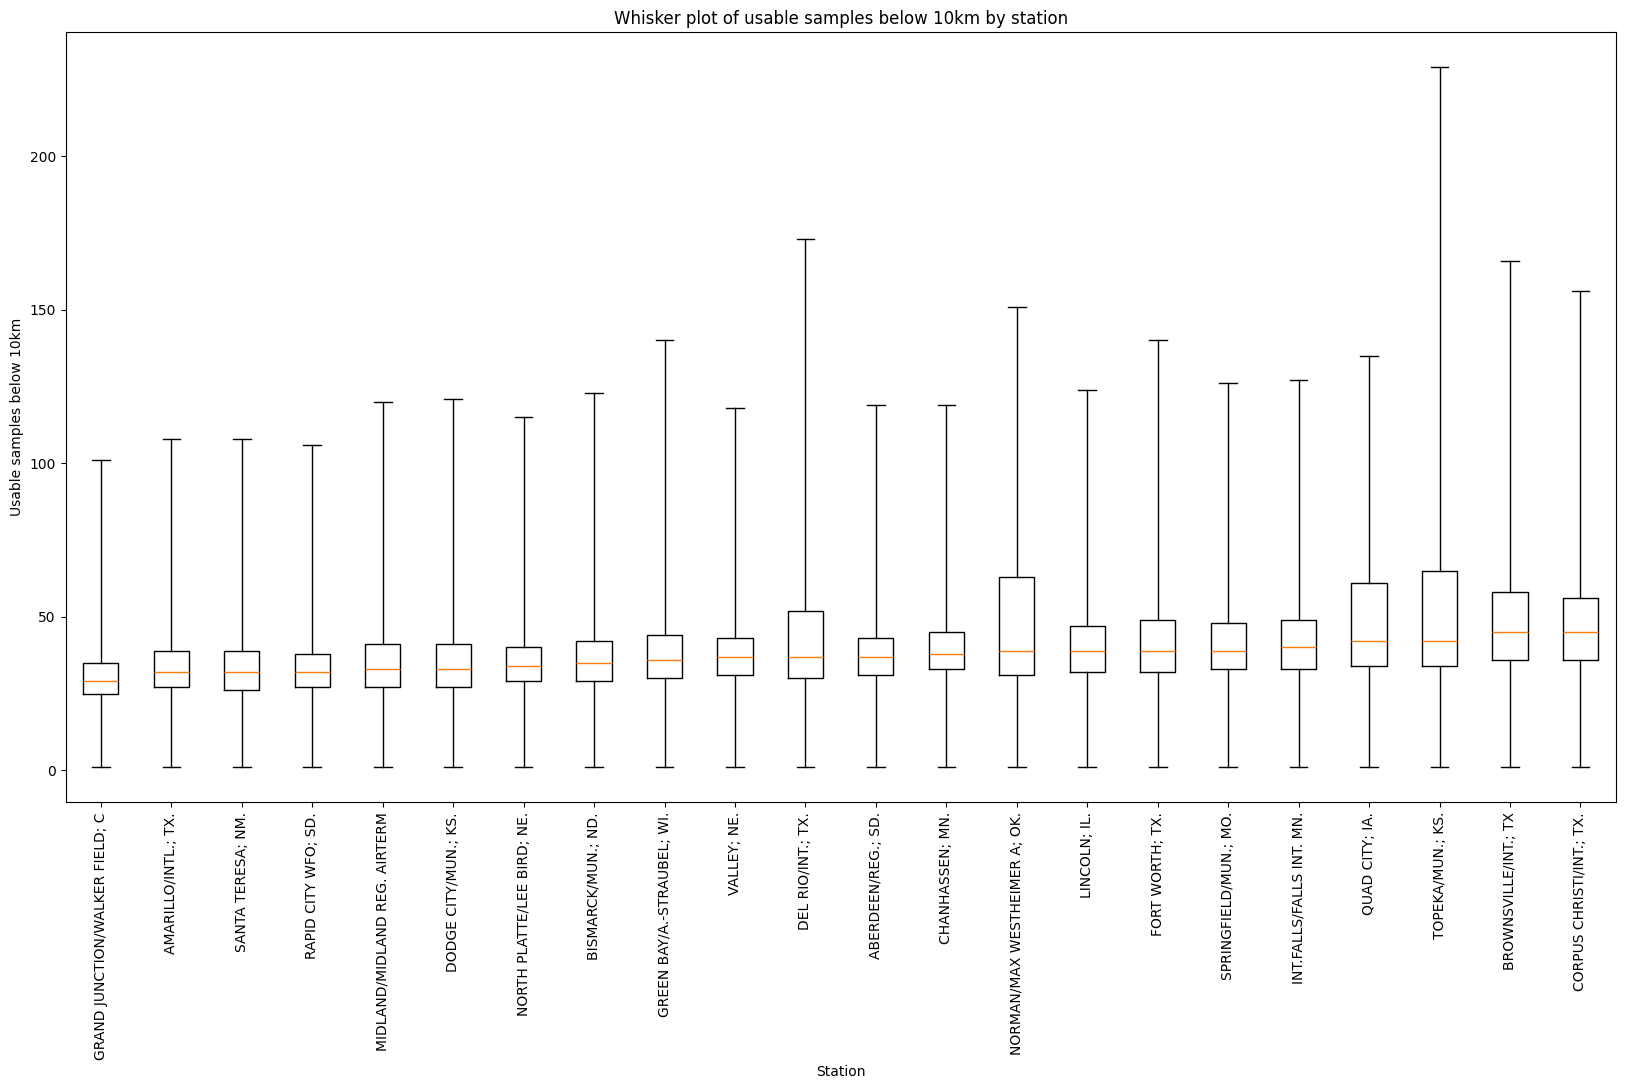

In [33]:
boxes = []

for index, row in query.iterrows():
    boxes.append({
        'label' : index,
        'whislo': row.whislo,   # Bottom whisker position
        'q1'    : row.q1,       # First quartile (25th percentile)
        'med'   : row.med,      # Median         (50th percentile)
        'q3'    : row.q3,       # Third quartile (75th percentile)
        'whishi': row.whishi,   # Top whisker position
        'fliers': []            # Outliers
    })

fig, ax = plt.subplots(figsize=(20, 10))

ax.bxp(boxes, showfliers=False)
ax.set_ylabel('Usable samples below 10km')
ax.set_xlabel('Station')
ax.set_title('Whisker plot of usable samples below 10km by station')
ax.tick_params(axis='x', labelrotation=90)

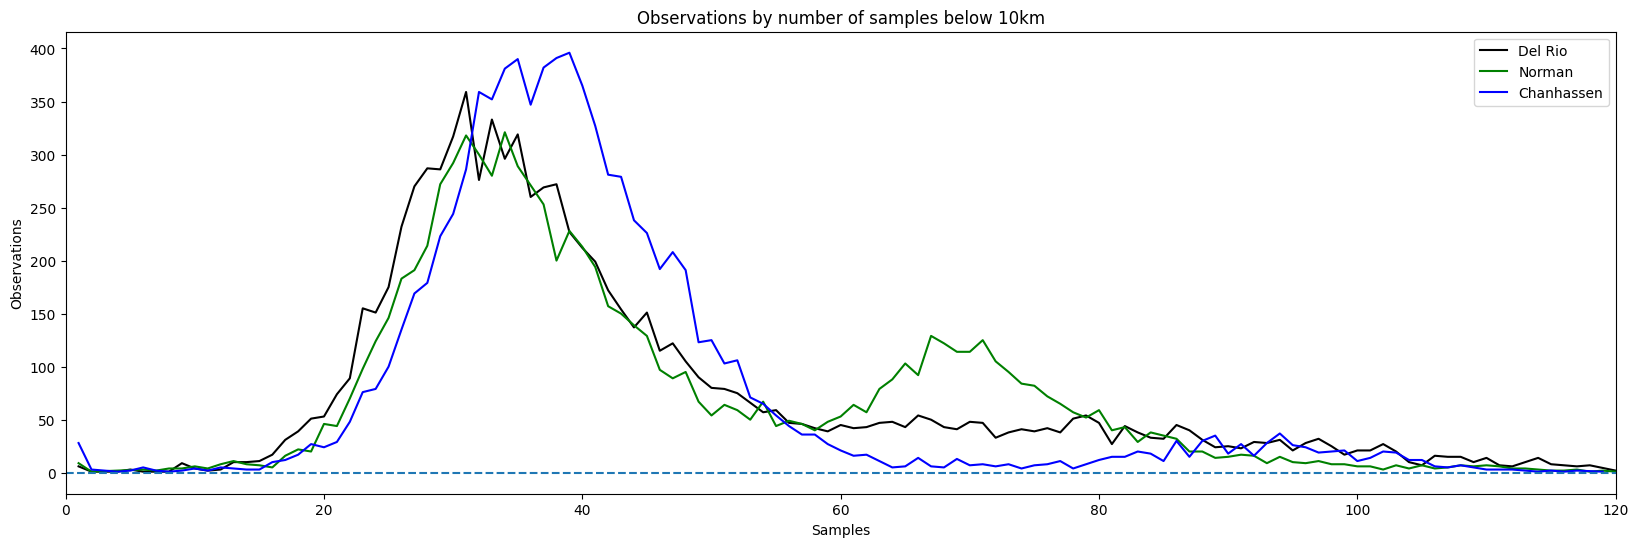

In [19]:
def PlotHistogram(ax, station_name: str, color: str):
    # Get the id for the given name
    station_id = df_stations[df_stations.name == station_name].iloc[0].id

    # Get the counts by usable_10k
    query = df[(df.hour == 12) & (df.id == station_id)] \
        .groupby('usable_10k') \
        .agg(obs_count = ('usable_10k', 'count'))
    
    # Plot the histogram
    ax.plot(query.index, query.obs_count, c=color)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 6))

# Plot some data
PlotHistogram(ax, "DEL RIO/INT.; TX.", 'k')
PlotHistogram(ax, "NORMAN/MAX WESTHEIMER A; OK.", 'g')
PlotHistogram(ax, "CHANHASSEN; MN.", 'b')

# Configure the axes
ax.set_ylabel('Observations')
ax.set_xlabel('Samples')
ax.set_title('Observations by number of samples below 10km')
ax.legend(['Del Rio', 'Norman', 'Chanhassen'])
ax.hlines(0, 0, 120, linestyles='dashed')
ax.set_xlim(0, 120)

# Display the graph
plt.show()

In [ ]:
# SELECT
#     s.name
#     ,min(max_gph) AS whislo
#     ,percentile(max_gph, 0.25) AS q1
#     ,percentile(max_gph, 0.5) AS med
#     ,percentile(max_gph, 0.75) AS q3
#     ,max(max_gph) AS whishi
# FROM df d INNER JOIN df_stations s on d.id = s.id
# WHERE hour = 12
# GROUP BY s.name
# ORDER BY med
query = df[df.hour == 12] \
    .merge(df_stations, how='inner', on='id') \
    .assign(max_gph = lambda a: a.max_gph / 1000.0) \
    .groupby('name')['max_gph'] \
    .quantile([0.0, 0.25, 0.5, 0.75, 1.0]).unstack() \
    .rename(columns={0: 'whislo', 0.25: 'q1', 0.5: 'med', 0.75: 'q3', 1: 'whishi'}) \
    .sort_values('med')

query

,whislo,q1,med,q3,whishi
name,,,,,
INT.FALLS/FALLS INT. MN.,0.357,26.86250,31.0870,32.51200,37.463
NORMAN/MAX WESTHEIMER A,0.345,28.18700,31.3120,32.53200,37.807
LINCOLN,0.178,26.25400,31.3585,32.81700,38.000
DODGE CITY/MUN.,0.788,29.26400,31.3820,32.65000,37.823
VALLEY,0.351,29.40200,31.4790,32.72700,37.215
GREEN BAY/A.-STRAUBEL,0.209,29.44900,31.4800,32.73700,37.233
CHANHASSEN,0.290,29.80200,31.6010,32.86000,38.348
DEL RIO/INT.,0.314,27.69000,31.6795,33.09925,38.412
BROWNSVILLE/INT.,0.007,30.33725,31.7620,32.73800,36.236


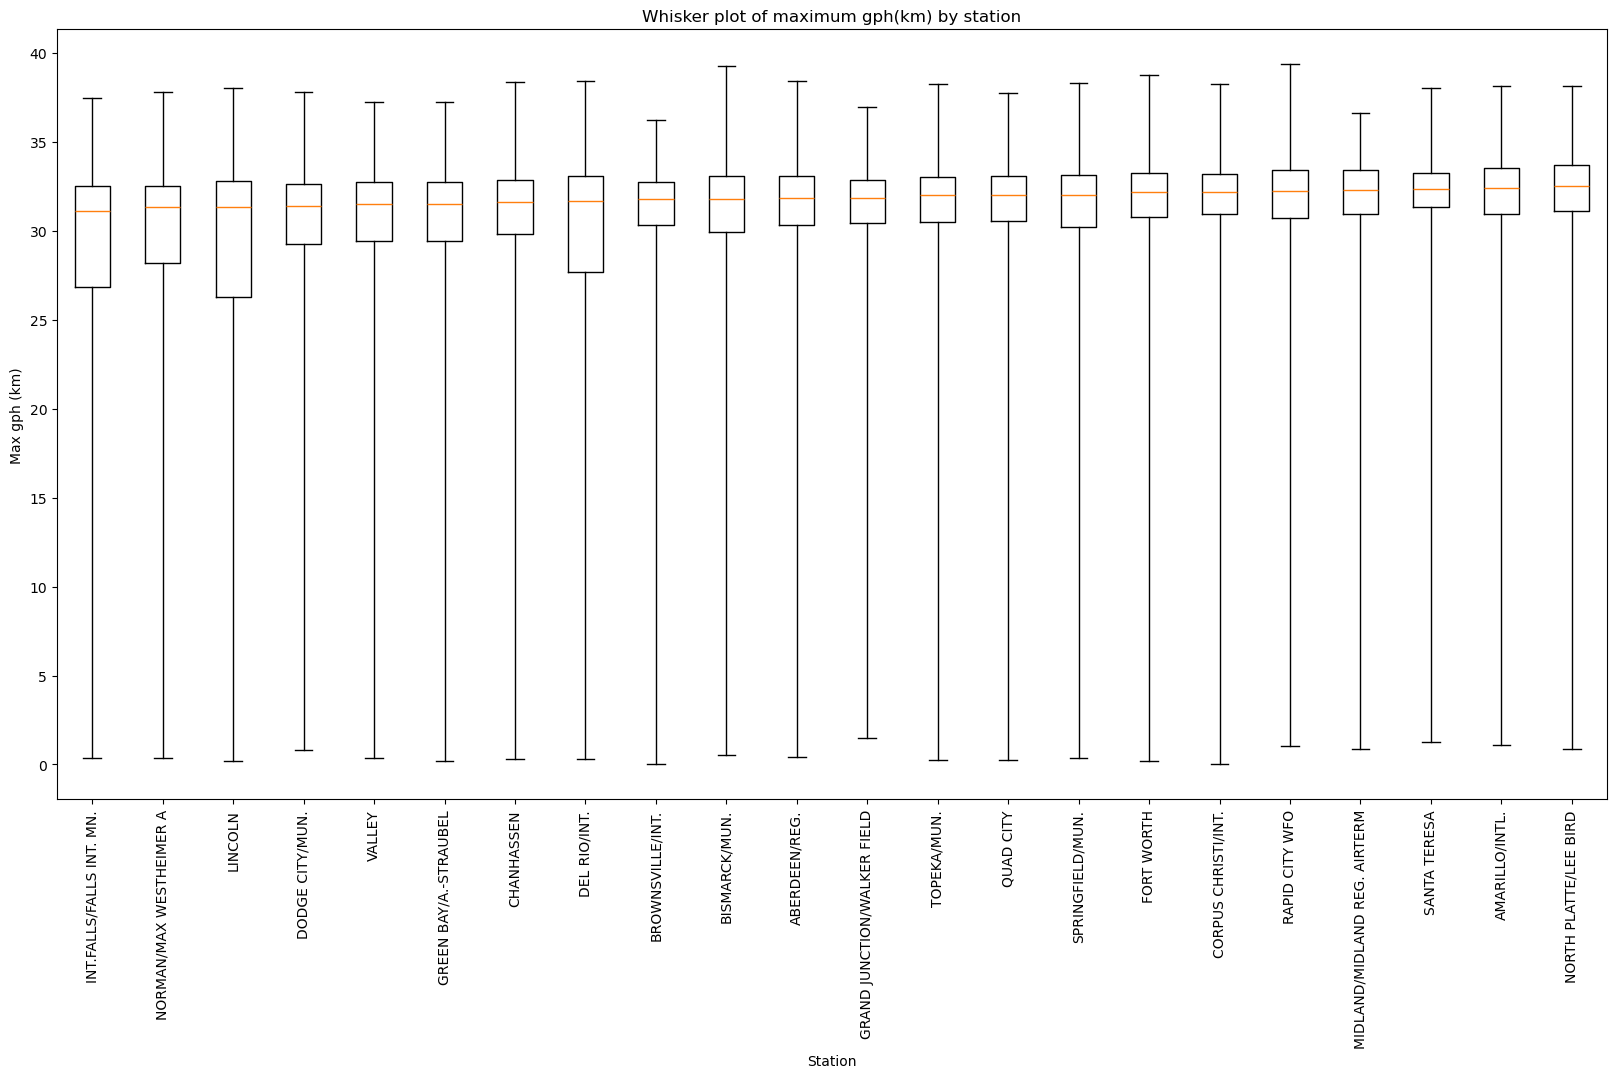

In [ ]:
boxes = []

for index, row in query.iterrows():
    boxes.append({
        'label' : index,
        'whislo': row.whislo,   # Bottom whisker position
        'q1'    : row.q1,       # First quartile (25th percentile)
        'med'   : row.med,      # Median         (50th percentile)
        'q3'    : row.q3,       # Third quartile (75th percentile)
        'whishi': row.whishi,   # Top whisker position
        'fliers': []            # Outliers
    })

fig, ax = plt.subplots(figsize=(20, 10))

ax.bxp(boxes, showfliers=False)
ax.set_ylabel('Max gph (km)')
ax.set_xlabel('Station')
ax.set_title('Whisker plot of maximum gph(km) by station')
ax.tick_params(axis='x', labelrotation=90)